In [1]:
import contextily as cx
import pandas as pd
import geopandas as gpd
import urbanpy as up
import numpy as np
import matplotlib.pyplot as plt
import json

## Read data

In [2]:
manzanas_lima = gpd.read_file('/Users/claudio/Documents/prep-covid-19/inputs/Manzanas/')

In [3]:
manzanas_lima.shape

(106889, 16)

In [4]:
manzanas_lima.columns

Index(['IDMANZANA', 'CODZONA', 'CODMZNA', 'CLASIFICAC', 'UBIGEO', 'NOMBREMZNA',
       'URBANIZACI', 'NSE07', 'POB07', 'VIV07', 'NSE16', 'POB16', 'VIV',
       'LONGITUDE', 'LATITUDE', 'geometry'],
      dtype='object')

In [5]:
areas_verdes_lima = gpd.read_file('/Users/claudio/Documents/prep-covid-19/inputs/Areas Verdes/')

In [6]:
areas_verdes_lima.shape

(14226, 3)

In [7]:
areas_verdes_lima.columns

Index(['UBIGEO', 'NOMBRE', 'geometry'], dtype='object')

## Download politic limits

In [8]:
lurin = up.download.nominatim_osm('Lurin, Peru')
lurin.crs = 'EPSG:4326'

In [43]:
pachacamac = up.download.nominatim_osm('Pachacámac, Peru', expected_position=2)
pachacamac.crs = 'EPSG:4326'

In [44]:
pachacamac

geometry   place_id  osm_type  \
2  POLYGON ((-76.91258 -12.12672, -76.91257 -12.1...  282613584  relation   

    osm_id                                      display_name  place_rank  \
2  1944779  Pachacámac, Lima, Lima Metropolitana, Lima, Perú          16   

   category            type  importance  \
2  boundary  administrative    0.362344   

                                                icon  
2  https://nominatim.openstreetmap.org/ui/mapicon...

In [45]:
carabayllo = up.download.nominatim_osm('Carabayllo, Peru')
carabayllo.crs = 'EPSG:4326'

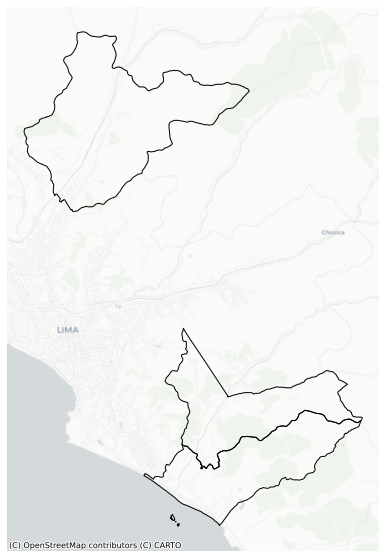

In [46]:
ax = carabayllo.plot(edgecolor='k', facecolor='none', figsize=(15,10))
pachacamac.plot(edgecolor='k', facecolor='none', ax=ax)
lurin.plot(edgecolor='k', facecolor='none', ax=ax)

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

## Lurin

In [13]:
lurin_food_pois = up.download.overpass_pois(facilities='food', bounds=lurin.total_bounds)
lurin_food_pois.crs = 'EPSG:4326'

In [14]:
lurin_food_pois = gpd.clip(lurin_food_pois, lurin)

In [15]:
lurin_food_pois['poi_type'].value_counts()

convenience    5
kiosk          3
supermarket    2
marketplace    2
mall           1
Name: poi_type, dtype: int64

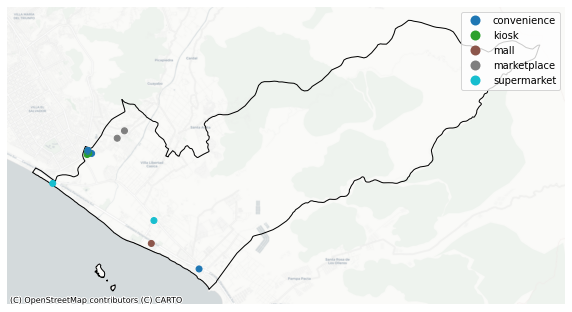

In [16]:
ax = lurin.plot(edgecolor='k', facecolor='none', figsize=(10,20))
lurin_food_pois.plot('poi_type', legend=True, ax=ax)

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [17]:
# Check marketplace info
_ = lurin_food_pois.query("poi_type == 'marketplace'")['tags'].apply(lambda x: print(json.dumps(x, indent=2)))

{
  "addr:city": "Las Palmas",
  "amenity": "marketplace",
  "name": "Mercado Se\u00f1or de los Milagros"
}
{
  "addr:city": "Lur\u00edn",
  "addr:street": "Avenida Las Palmas",
  "amenity": "marketplace",
  "name": "Centro Comercial Villa Las Palmas"
}


In [18]:
# Download restaurants
query = """
[timeout:120][out:json][bbox];
(
  node["amenity"="restaurant"];
);
out body geom;
"""
response = up.download.overpass_pois(lurin.total_bounds, custom_query=query)
data = response.json() # get json data
lurin_restaurants_df = pd.DataFrame.from_dict(data['elements']) # transform data to dataframe
# Build GeoDataFrame and Geometry
lurin_restaurants_gdf = gpd.GeoDataFrame(
    lurin_restaurants_df, 
    geometry=gpd.points_from_xy(
        lurin_restaurants_df['lon'],
        lurin_restaurants_df['lat']),
    crs = 'EPSG:4326'
)

In [19]:
lurin_restaurants_gdf = gpd.clip(lurin_restaurants_gdf, lurin)

In [20]:
lurin_restaurants_gdf.shape

(29, 6)

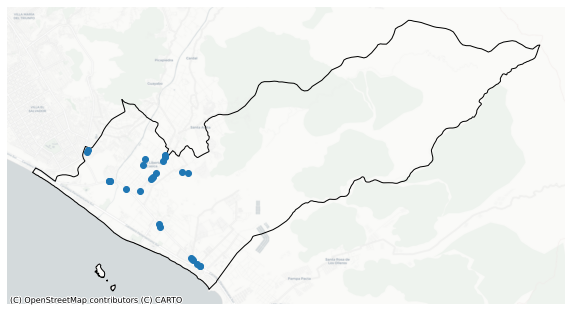

In [21]:
ax = lurin.plot(edgecolor='k', facecolor='none', figsize=(10,20))
lurin_restaurants_gdf.plot(ax=ax)

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [22]:
lurin_food_pois.head()

type          id        lat        lon  \
0   node  2692670974 -12.274071 -76.873390   
17  node  4354653654 -12.237914 -76.909959   
19  node  4355942308 -12.237328 -76.907529   
20  node  4355976689 -12.237293 -76.909077   
21  node  4356014546 -12.236108 -76.909668   

                                                 tags  \
0   {'addr:city': 'Lurín', 'addr:housenumber': 'Km...   
17  {'addr:street': 'Avenida de los Incas', 'name'...   
19  {'addr:city': 'Lurín', 'addr:street': 'Calle 3...   
20  {'addr:street': 'Avenida De Los Incas', 'shop'...   
21  {'addr:street': 'Calle Daniel Alcides Carrion'...   

                       geometry     poi_type  
0   POINT (-76.87339 -12.27407)  supermarket  
17  POINT (-76.90996 -12.23791)        kiosk  
19  POINT (-76.90753 -12.23733)  convenience  
20  POINT (-76.90908 -12.23729)        kiosk  
21  POINT (-76.90967 -12.23611)  convenience

In [23]:
lurin_restaurants_gdf['poi_type'] = 'restaurant'

In [24]:
lurin_food_pois = pd.concat([lurin_food_pois, lurin_restaurants_gdf])

### Create centrality bands

In [25]:
lurin_markets = lurin_food_pois[lurin_food_pois['poi_type'] == 'marketplace']

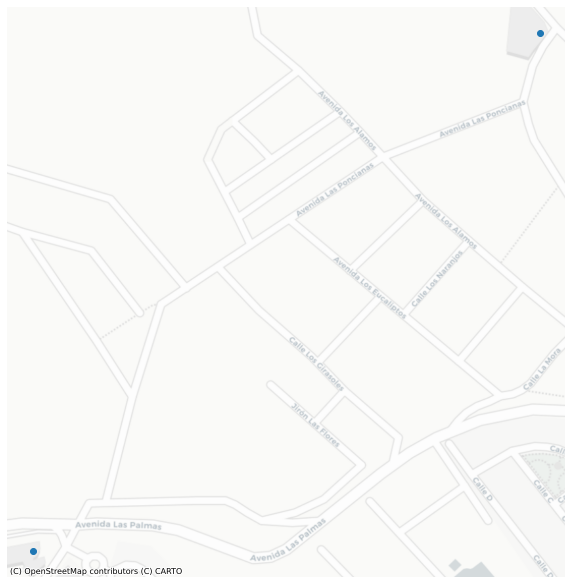

In [26]:
ax = lurin_markets.plot(figsize=(10,20))

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [27]:
lurin_markets_proj = lurin_markets.to_crs('EPSG:32718')

In [28]:
lurin_markets_centroid = lurin_markets_proj.unary_union.centroid

In [29]:
area_bands = [400, 800, 1500]
lurin_centralidad_gdf_proj = gpd.GeoDataFrame(
    geometry=[lurin_markets_centroid] + [lurin_markets_centroid.buffer(m) for m in area_bands],
    crs='EPSG:32718')
lurin_centralidad_gdf = lurin_centralidad_gdf_proj.to_crs('EPSG:4326')
centrality_sizes = [str(i)+' m' for i in [0] + area_bands]
lurin_centralidad_gdf['size'] = centrality_sizes

### Make visualizations

In [30]:
minx, miny, maxx, maxy = lurin.total_bounds

In [31]:
# Filter GeoDataFrames with Lurin bounds
lurin_manzanas_lima = manzanas_lima.cx[minx:maxx, miny:maxy]
lurin_areas_verdes_lima = areas_verdes_lima.cx[minx:maxx, miny:maxy]

In [32]:
nse_categories = ['AL', 'MA', 'ME', 'MB', 'BA']

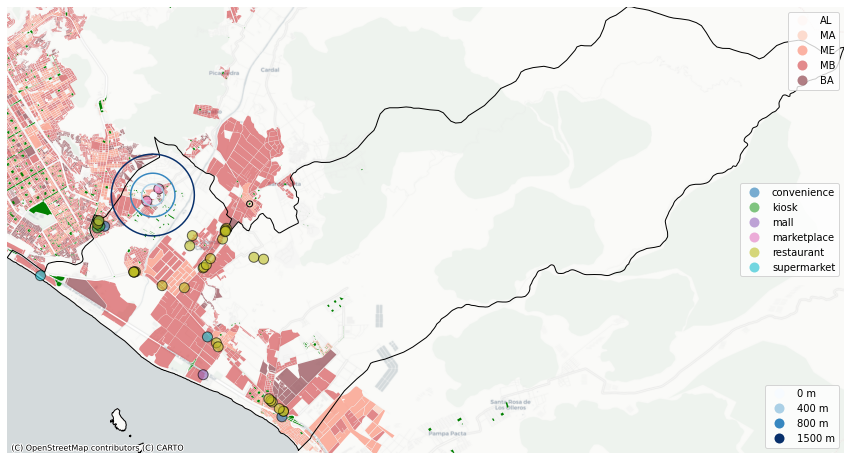

In [33]:
fig, ax = plt.subplots(figsize=(15,10))

# Socioeconomic levels choroplet map
lurin_manzanas_lima.plot('NSE16', categories=nse_categories, cmap='Reds', alpha=0.5, edgecolor='none', legend=True, legend_kwds={'loc': 'upper right'}, ax=ax)
nse_legend = ax.get_legend() # Extract legend 1

# Add green areas
lurin_areas_verdes_lima.plot(color='g', edgecolor='none', ax=ax)

# Politic limits
pachacamac.plot(edgecolor='k', facecolor='none', ax=ax)
lurin.plot(edgecolor='k', facecolor='none', ax=ax)

# Add Points of Interest
lurin_food_pois.plot('poi_type', alpha=0.6, markersize=100, edgecolor='k', legend=True, legend_kwds={'loc': 'center right'}, ax=ax)
pois_legend = ax.get_legend() # Extract legend 2, legend 1 would be removed

# Add centrality bands
lurin_centralidad_gdf.plot('size', categories=centrality_sizes, cmap='Blues', linewidth=1.5, facecolor='none', legend=True, legend_kwds={'loc': 'lower right'}, ax=ax)
centralidad_legend = ax.get_legend() # Extract legend 3, legend 2 would be removed

# Manually add legend 1 back
ax.add_artist(nse_legend) 
ax.add_artist(pois_legend)

# Zoom to lurin bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

plt.savefig('mapa_lurin.png', dpi=300, bbox_inches='tight')

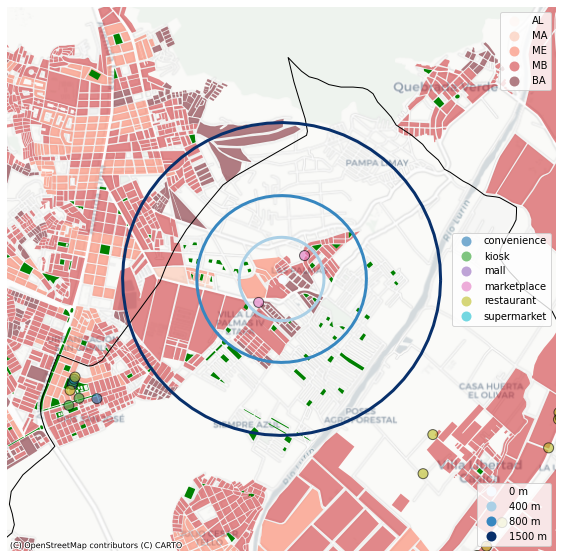

In [34]:
fig, ax = plt.subplots(figsize=(15,10))

# Socioeconomic levels choroplet map
lurin_manzanas_lima.plot('NSE16', categories=nse_categories, cmap='Reds', alpha=0.5, edgecolor='none', legend=True, legend_kwds={'loc': 'upper right'}, ax=ax)
nse_legend = ax.get_legend() # Extract legend 1

# Add green areas
lurin_areas_verdes_lima.plot(color='g', edgecolor='none', ax=ax)

# Politic limits
pachacamac.plot(edgecolor='k', facecolor='none', ax=ax)
lurin.plot(edgecolor='k', facecolor='none', ax=ax)

# Add Points of Interest
lurin_food_pois.plot('poi_type', alpha=0.6, markersize=100, edgecolor='k', legend=True, legend_kwds={'loc': 'center right'}, ax=ax)
pois_legend = ax.get_legend() # Extract legend 2, legend 1 would be removed

# Add centrality bands
lurin_centralidad_gdf.plot('size', categories=centrality_sizes, cmap='Blues', linewidth=3, facecolor='none', legend=True, legend_kwds={'loc': 'lower right'}, ax=ax)
centralidad_legend = ax.get_legend() # Extract legend 3, legend 2 would be removed

# Manually add legend 1 and 2 back
ax.add_artist(nse_legend)
ax.add_artist(pois_legend)

# Zoom to market centrality bounds
c_minx, c_miny, c_maxx, c_maxy = lurin_centralidad_gdf.total_bounds
c_minx, c_miny = c_minx - 0.01, c_miny - 0.01
c_maxx, c_maxy = c_maxx + 0.01, c_maxy + 0.01
ax.set_xlim(c_minx, c_maxx)
ax.set_ylim(c_miny, c_maxy)

# Add basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

plt.savefig('mapa_lurin_zoom.png', dpi=300, bbox_inches='tight')

## Pachacamac

<AxesSubplot:>

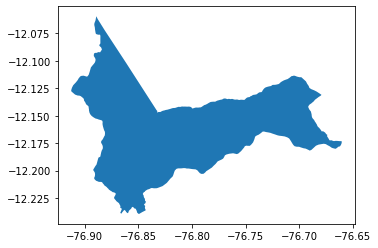

In [47]:
pachacamac.plot()

In [48]:
pachacamac_food_pois = up.download.overpass_pois(facilities='food', bounds=pachacamac.total_bounds)
pachacamac_food_pois.crs = 'EPSG:4326'

In [49]:
pachacamac_food_pois = gpd.clip(pachacamac_food_pois, pachacamac)

In [50]:
pachacamac_food_pois['poi_type'].value_counts()

convenience    8
marketplace    1
kiosk          1
Name: poi_type, dtype: int64

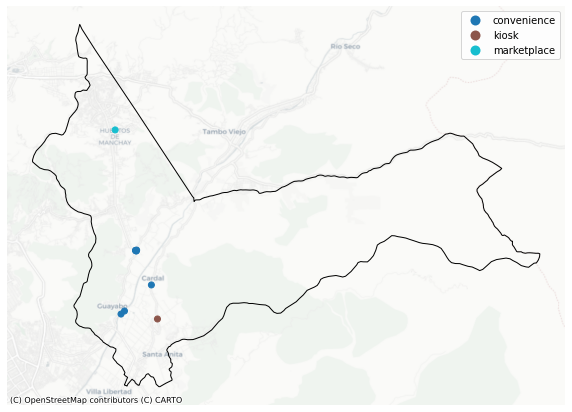

In [51]:
ax = pachacamac.plot(edgecolor='k', facecolor='none', figsize=(10,20))
pachacamac_food_pois.plot('poi_type', legend=True, ax=ax)

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [52]:
# Check marketplace info
_ = pachacamac_food_pois.query("poi_type == 'marketplace'")['tags'].apply(lambda x: print(json.dumps(x, indent=2)))

{
  "amenity": "marketplace"
}


In [53]:
# Download restaurants
query = """
[timeout:120][out:json][bbox];
(
  node["amenity"="restaurant"];
);
out body geom;
"""
response = up.download.overpass_pois(pachacamac.total_bounds, custom_query=query)
data = response.json() # get json data
pachacamac_restaurants_df = pd.DataFrame.from_dict(data['elements']) # transform data to dataframe
# Build GeoDataFrame and Geometry
pachacamac_restaurants_gdf = gpd.GeoDataFrame(
    pachacamac_restaurants_df, 
    geometry=gpd.points_from_xy(
        pachacamac_restaurants_df['lon'],
        pachacamac_restaurants_df['lat']),
    crs = 'EPSG:4326'
)

In [54]:
pachacamac_restaurants_gdf = gpd.clip(pachacamac_restaurants_gdf, pachacamac)

In [55]:
pachacamac_restaurants_gdf.shape

(6, 6)

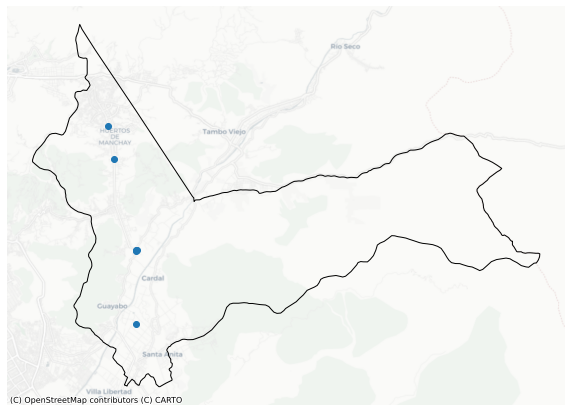

In [56]:
ax = pachacamac.plot(edgecolor='k', facecolor='none', figsize=(10,20))
pachacamac_restaurants_gdf.plot(ax=ax)

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [57]:
pachacamac_food_pois.head()

type          id        lat        lon                        tags  \
27  node  4785234450 -12.111844 -76.871513  {'amenity': 'marketplace'}   
28  node  5063161984 -12.171589 -76.860829     {'shop': 'convenience'}   
29  node  5063161987 -12.171803 -76.861364     {'shop': 'convenience'}   
30  node  5063161988 -12.171729 -76.861383     {'shop': 'convenience'}   
31  node  5063161989 -12.171953 -76.861118     {'shop': 'convenience'}   

                       geometry     poi_type  
27  POINT (-76.87151 -12.11184)  marketplace  
28  POINT (-76.86083 -12.17159)  convenience  
29  POINT (-76.86136 -12.17180)  convenience  
30  POINT (-76.86138 -12.17173)  convenience  
31  POINT (-76.86112 -12.17195)  convenience

In [58]:
pachacamac_restaurants_gdf['poi_type'] = 'restaurant'

In [59]:
pachacamac_food_pois = pd.concat([pachacamac_food_pois, pachacamac_restaurants_gdf])

### Create centrality bands

In [60]:
pachacamac_markets = pachacamac_food_pois[pachacamac_food_pois['poi_type'] == 'marketplace']

In [61]:
pachacamac_markets

type          id        lat        lon                        tags  \
27  node  4785234450 -12.111844 -76.871513  {'amenity': 'marketplace'}   

                       geometry     poi_type  
27  POINT (-76.87151 -12.11184)  marketplace

In [62]:
import shapely

In [63]:
pachacamac_markets = pachacamac_markets.append(
[{
    'tags': {'name': 'Mercado Municipal de Pachacamac', 'amenity': 'marketplace'},
    'poi_type': 'marketplace',
    'lat': -12.2301618,
    'lon': -76.857464,
    'geometry': shapely.geometry.Point(-76.857464, -12.2301618)
},
{
    'tags': {'name': 'Mercado Ocoña', 'amenity': 'marketplace'},
    'poi_type': 'marketplace',
    'lat': -12.2270251,
    'lon': -76.8611833,
    'geometry': shapely.geometry.Point(-76.8611833, -12.2270251)
}])

In [64]:
pachacamac_markets = pachacamac_markets.drop(27)

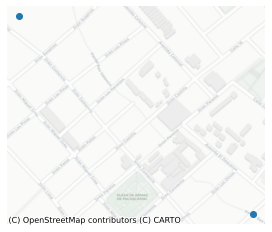

In [65]:
ax = pachacamac_markets.plot()

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [66]:
pachacamac_markets.crs = 'EPSG:4326'
pachacamac_markets_proj = pachacamac_markets.to_crs('EPSG:32718')

In [67]:
for ix, market in pachacamac_markets_proj.iterrows():
    print(market.geometry)

POINT (297938.8897702411 8647301.29720309)
POINT (297531.7730883422 8647645.537531862)


In [68]:
area_bands_sizes = [400, 800, 1500]

pachacamac_centralidades_gdf= gpd.GeoDataFrame()

area_bands = []
area_size = []
for ix, market in pachacamac_markets_proj.iterrows():
    area_bands.append(market.geometry)
    area_size.append("0 m")
    for m in area_bands_sizes:
        area_bands.append(market.geometry.buffer(m))
        area_size.append(f"{m} m")

pachacamac_centralidad_gdf_proj = gpd.GeoDataFrame(
    area_size,
    columns=['size'],
    geometry=area_bands, 
    crs='EPSG:32718'
)
pachacamac_centralidad_gdf = pachacamac_centralidad_gdf_proj.to_crs('EPSG:4326')

### Make visualizations

In [69]:
minx, miny, maxx, maxy = pachacamac_centralidad_gdf.total_bounds

In [70]:
# Filter GeoDataFrames with pachacamac bounds
pachacamac_manzanas_lima = manzanas_lima.cx[minx:maxx, miny:maxy]
pachacamac_areas_verdes_lima = areas_verdes_lima.cx[minx:maxx, miny:maxy]

In [71]:
nse_categories = ['AL', 'MA', 'ME', 'MB', 'BA']

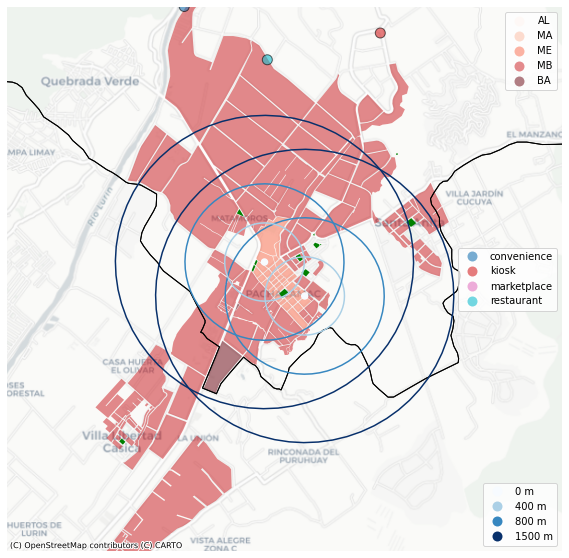

In [72]:
fig, ax = plt.subplots(figsize=(15,10))

# Socioeconomic levels choroplet map
pachacamac_manzanas_lima.plot('NSE16', categories=nse_categories, cmap='Reds', alpha=0.5, edgecolor='none', legend=True, legend_kwds={'loc': 'upper right'}, ax=ax)
nse_legend = ax.get_legend() # Extract legend 1

# Add green areas
pachacamac_areas_verdes_lima.plot(color='g', edgecolor='none', ax=ax)

# Politic limits
pachacamac.plot(edgecolor='k', facecolor='none', ax=ax)
lurin.plot(edgecolor='k', facecolor='none', ax=ax)

# Add Points of Interest
pachacamac_food_pois.plot('poi_type', alpha=0.6, markersize=100, edgecolor='k', legend=True, legend_kwds={'loc': 'center right'}, ax=ax)
pois_legend = ax.get_legend() # Extract legend 2, legend 1 would be removed

# Add centrality bands
pachacamac_centralidad_gdf.plot('size', categories=centrality_sizes, cmap='Blues', linewidth=1.5, facecolor='none', legend=True, legend_kwds={'loc': 'lower right'}, ax=ax)
centralidad_legend = ax.get_legend() # Extract legend 3, legend 2 would be removed

# Manually add legend 1 back
ax.add_artist(nse_legend) 
ax.add_artist(pois_legend)

# Zoom to pachacamac bounds
ax.set_xlim(minx-0.01, maxx+0.01)
ax.set_ylim(miny-0.01, maxy+0.01)

# Add basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

plt.savefig('mapa_pachacamac.png', dpi=300, bbox_inches='tight')

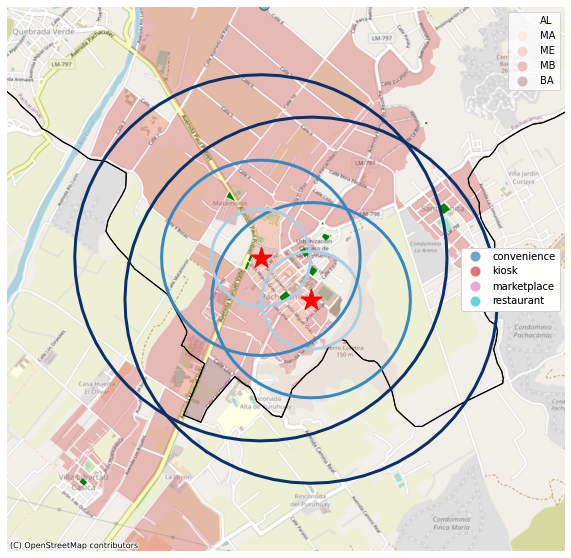

In [73]:
fig, ax = plt.subplots(figsize=(15,10))

# Socioeconomic levels choroplet map
pachacamac_manzanas_lima.plot('NSE16', categories=nse_categories, cmap='Reds', alpha=0.25, edgecolor='none', legend=True, legend_kwds={'loc': 'upper right'}, ax=ax)
nse_legend = ax.get_legend() # Extract legend 1

# Add green areas
pachacamac_areas_verdes_lima.plot(color='g', edgecolor='none', ax=ax)

# Politic limits
pachacamac.plot(edgecolor='k', facecolor='none', ax=ax)
lurin.plot(edgecolor='k', facecolor='none', ax=ax)

# Add centrality bands
pachacamac_centralidad_gdf.plot('size', categories=centrality_sizes, cmap='Blues', linewidth=3, facecolor='none', legend=True, legend_kwds={'loc': 'lower right'}, ax=ax)
centralidad_legend = ax.get_legend() # Extract legend 3, legend 2 would be removed
(pachacamac_centralidad_gdf
 .query("size == '0 m'")
 .plot(color='r', marker='*', markersize=500, ax=ax))

# Add Points of Interest
pachacamac_food_pois.plot('poi_type', alpha=0.6, markersize=100, edgecolor='k', legend=True, legend_kwds={'loc': 'center right'}, ax=ax)
pois_legend = ax.get_legend() # Extract legend 2, legend 1 would be removed

# Manually add legend 1 and 2 back
ax.add_artist(nse_legend)
ax.add_artist(pois_legend)

# Zoom to market centrality bounds
c_minx, c_miny, c_maxx, c_maxy = pachacamac_centralidad_gdf.total_bounds
c_minx, c_miny = c_minx - 0.005, c_miny - 0.005
c_maxx, c_maxy = c_maxx + 0.005, c_maxy + 0.005
ax.set_xlim(c_minx, c_maxx)
ax.set_ylim(c_miny, c_maxy)

# Add basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs='EPSG:4326')

plt.savefig('mapa_pachacamac_zoom.png', dpi=300, bbox_inches='tight')

## Carabayllo

In [74]:
carabayllo_food_pois = up.download.overpass_pois(facilities='food', bounds=carabayllo.total_bounds)
carabayllo_food_pois.crs = 'EPSG:4326'

In [75]:
carabayllo_food_pois = gpd.clip(carabayllo_food_pois, carabayllo)

In [76]:
carabayllo_food_pois['poi_type'].value_counts()

convenience    10
butcher         3
greengrocer     2
marketplace     2
supermarket     1
Name: poi_type, dtype: int64

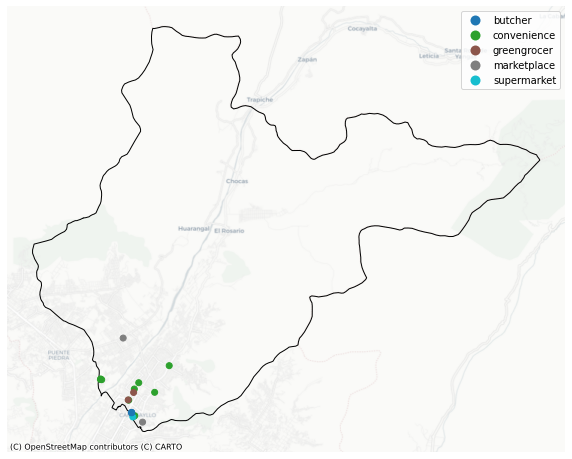

In [77]:
ax = carabayllo.plot(edgecolor='k', facecolor='none', figsize=(10,20))
carabayllo_food_pois.plot('poi_type', legend=True, ax=ax)

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [78]:
# Check marketplace info
_ = carabayllo_food_pois.query("poi_type == 'marketplace'")['tags'].apply(lambda x: print(json.dumps(x, indent=2)))

{
  "amenity": "marketplace",
  "name": "Mercado El Establo"
}
{
  "amenity": "marketplace",
  "name": "Mercado El Pino"
}


In [79]:
# Download restaurants
query = """
[timeout:120][out:json][bbox];
(
  node["amenity"="restaurant"];
);
out body geom;
"""
response = up.download.overpass_pois(carabayllo.total_bounds, custom_query=query)
data = response.json() # get json data
carabayllo_restaurants_df = pd.DataFrame.from_dict(data['elements']) # transform data to dataframe
# Build GeoDataFrame and Geometry
carabayllo_restaurants_gdf = gpd.GeoDataFrame(
    carabayllo_restaurants_df, 
    geometry=gpd.points_from_xy(
        carabayllo_restaurants_df['lon'],
        carabayllo_restaurants_df['lat']),
    crs = 'EPSG:4326'
)

In [80]:
carabayllo_restaurants_gdf = gpd.clip(carabayllo_restaurants_gdf, carabayllo)

In [81]:
carabayllo_restaurants_gdf.shape

(45, 6)

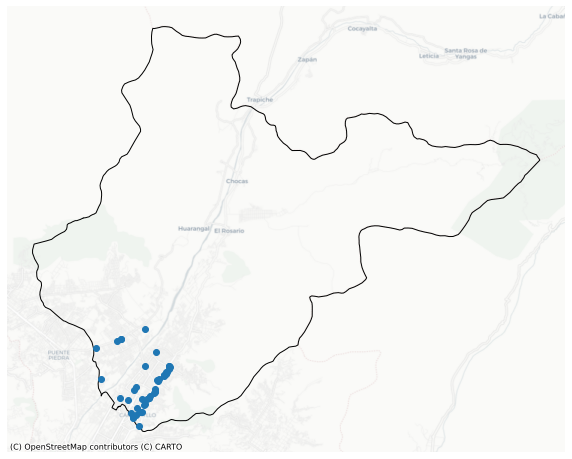

In [82]:
ax = carabayllo.plot(edgecolor='k', facecolor='none', figsize=(10,20))
carabayllo_restaurants_gdf.plot(ax=ax)

ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

In [83]:
carabayllo_food_pois.head()

type          id        lat        lon  \
4   node  4332767413 -11.892245 -77.038459   
8   node  4333070720 -11.882331 -77.032757   
9   node  4333079931 -11.885915 -77.035264   
10  node  4334007158 -11.892096 -77.038754   
13  node  4335597030 -11.901081 -77.035040   

                                                 tags  \
4   {'addr:street': 'Avenida Mariano Condorcanqui'...   
8   {'addr:street': 'Avenida Parque Zonal', 'name'...   
9   {'addr:street': 'Avenida Mariano Condorcanqui'...   
10  {'addr:street': 'Avenida Mariano Condorcanqui'...   
13  {'addr:street': 'Avenida San Martin', 'shop': ...   

                       geometry     poi_type  
4   POINT (-77.03846 -11.89225)  convenience  
8   POINT (-77.03276 -11.88233)  convenience  
9   POINT (-77.03526 -11.88591)  convenience  
10  POINT (-77.03875 -11.89210)  greengrocer  
13  POINT (-77.03504 -11.90108)  convenience

In [84]:
carabayllo_restaurants_gdf['poi_type'] = 'restaurant'

In [85]:
carabayllo_food_pois = pd.concat([carabayllo_food_pois, carabayllo_restaurants_gdf])

### Create centrality bands

In this case the market selected is Qatuna, but it is not present in the OSM data. Thus, we will add it manually.

In [86]:
import shapely
import pyproj

In [87]:
carabayllo_markets_centroid_gdf = gpd.GeoSeries(shapely.geometry.Point(-77.0457346, -11.8903726), crs='EPSG:4326')

In [88]:
carabayllo_markets_centroid_gdf = carabayllo_markets_centroid_gdf.to_crs('EPSG:32718')
carabayllo_markets_centroid = carabayllo_markets_centroid_gdf[0]

In [89]:
area_bands = [400, 800, 1500]
carabayllo_centralidad_gdf_proj = gpd.GeoDataFrame(
    geometry=[carabayllo_markets_centroid] + [carabayllo_markets_centroid.buffer(m) for m in area_bands],
    crs='EPSG:32718')
carabayllo_centralidad_gdf = carabayllo_centralidad_gdf_proj.to_crs('EPSG:4326')
centrality_sizes = [str(i)+' m' for i in [0] + area_bands]
carabayllo_centralidad_gdf['size'] = centrality_sizes

### Make visualizations

In [90]:
minx, miny, maxx, maxy = carabayllo.total_bounds

In [91]:
# Filter GeoDataFrames with carabayllo bounds
carabayllo_manzanas_lima = manzanas_lima.cx[minx:maxx, miny:maxy]
carabayllo_areas_verdes_lima = areas_verdes_lima.cx[minx:maxx, miny:maxy]

In [92]:
nse_categories = ['AL', 'MA', 'ME', 'MB', 'BA']

In [93]:
carabayllo_manzanas_lima.loc[:, 'NSE16'] = carabayllo_manzanas_lima['NSE16'].replace('-7', pd.np.nan).values

/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_75384/1599826314.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  carabayllo_manzanas_lima.loc[:, 'NSE16'] = carabayllo_manzanas_lima['NSE16'].replace('-7', pd.np.nan).values
/Users/claudio/Documents/proyecto-foodhub-lima/.env/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [94]:
carabayllo_centralidad_gdf.query("size == '0 m'")

geometry size
0  POINT (-77.04573 -11.89037)  0 m

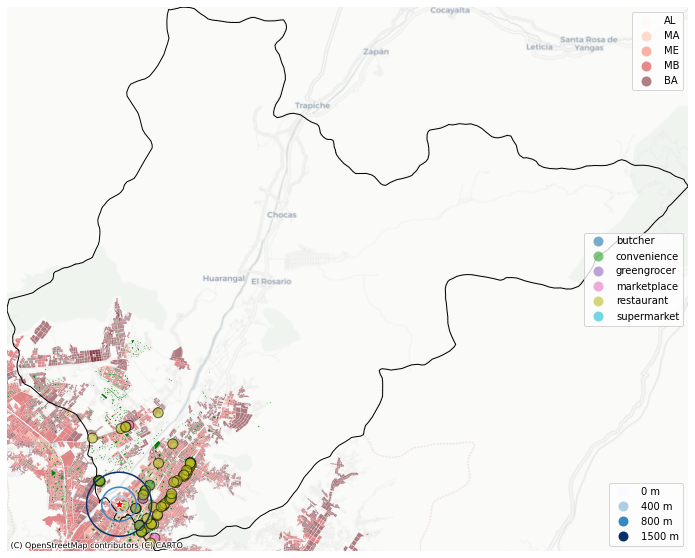

In [95]:
fig, ax = plt.subplots(figsize=(15,10))

# Socioeconomic levels choroplet map
carabayllo_manzanas_lima.plot('NSE16', categories=nse_categories, cmap='Reds', alpha=0.5, edgecolor='none', legend=True, legend_kwds={'loc': 'upper right'}, ax=ax)
nse_legend = ax.get_legend() # Extract legend 1

# Add green areas
carabayllo_areas_verdes_lima.plot(color='g', edgecolor='none', ax=ax)

# Politic limits
carabayllo.plot(edgecolor='k', facecolor='none', ax=ax)

# Add Points of Interest
carabayllo_food_pois.plot('poi_type', alpha=0.6, markersize=100, edgecolor='k', legend=True, legend_kwds={'loc': 'center right'}, ax=ax)
pois_legend = ax.get_legend() # Extract legend 2, legend 1 would be removed

# Add centrality bands
carabayllo_centralidad_gdf.plot('size', categories=centrality_sizes, cmap='Blues', linewidth=1.5, facecolor='none', legend=True, legend_kwds={'loc': 'lower right'}, ax=ax)
centralidad_legend = ax.get_legend() # Extract legend 3, legend 2 would be removed
(carabayllo_centralidad_gdf
 .query("size == '0 m'")
 .plot(color='r', marker='*', ax=ax))

# Manually add legend 1 back
ax.add_artist(nse_legend) 
ax.add_artist(pois_legend)

# Zoom to carabayllo bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

plt.savefig('mapa_carabayllo.png', dpi=300, bbox_inches='tight')

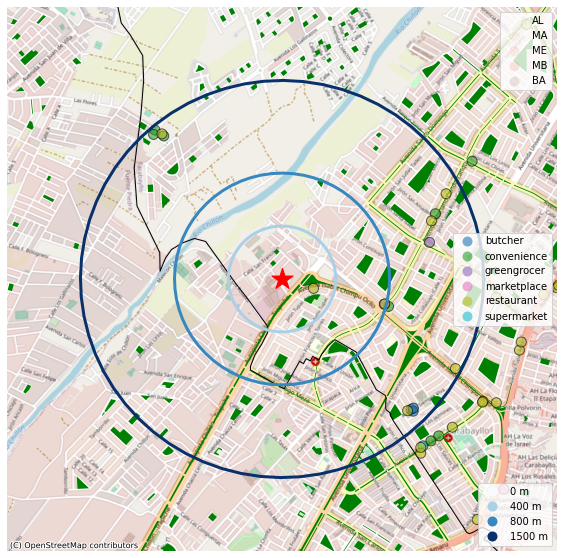

In [96]:
fig, ax = plt.subplots(figsize=(15,10))

# Socioeconomic levels choroplet map
carabayllo_manzanas_lima.plot('NSE16', categories=nse_categories, cmap='Reds', alpha=0.1, edgecolor='none', legend=True, legend_kwds={'loc': 'upper right'}, ax=ax)
nse_legend = ax.get_legend() # Extract legend 1

# Add green areas
carabayllo_areas_verdes_lima.plot(color='g', edgecolor='none', ax=ax)

# Politic limits
carabayllo.plot(edgecolor='k', facecolor='none', ax=ax)
lurin.plot(edgecolor='k', facecolor='none', ax=ax)

# Add Points of Interest
carabayllo_food_pois.plot('poi_type', alpha=0.6, markersize=100, edgecolor='k', legend=True, legend_kwds={'loc': 'center right'}, ax=ax)
pois_legend = ax.get_legend() # Extract legend 2, legend 1 would be removed

# Add centrality bands
carabayllo_centralidad_gdf.plot('size', categories=centrality_sizes, cmap='Blues', linewidth=3, facecolor='none', legend=True, legend_kwds={'loc': 'lower right'}, ax=ax)
centralidad_legend = ax.get_legend() # Extract legend 3, legend 2 would be removed
(carabayllo_centralidad_gdf
 .query("size == '0 m'")
 .plot(color='r', marker='*', markersize=500, ax=ax))

# Manually add legend 1 and 2 back
ax.add_artist(nse_legend)
ax.add_artist(pois_legend)

# Zoom to market centrality bounds
c_minx, c_miny, c_maxx, c_maxy = carabayllo_centralidad_gdf.total_bounds
c_minx, c_miny = c_minx - 0.005, c_miny - 0.005
c_maxx, c_maxy = c_maxx + 0.005, c_maxy + 0.005
ax.set_xlim(c_minx, c_maxx)
ax.set_ylim(c_miny, c_maxy)

# plt.title('Mercado de Qatuna - Bandas de accesibilidad')

# Add basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs='EPSG:4326')

plt.savefig('mapa_carabayllo_zoom.png', dpi=300, bbox_inches='tight')

In [97]:
market # Mercado Ocoña


type                                                      NaN
id                                                        NaN
lat                                                -12.227025
lon                                                -76.861183
tags        {'name': 'Mercado Ocoña', 'amenity': 'marketpl...
geometry          POINT (297531.7730883422 8647645.537531862)
poi_type                                          marketplace
Name: 1, dtype: object

In [98]:
qatuna = carabayllo_centralidad_gdf.query("size == '0 m'").geometry

In [99]:
qatuna

0    POINT (-77.04573 -11.89037)
Name: geometry, dtype: geometry

In [100]:
markets = gpd.GeoDataFrame({"nombre": ["Ocoña", "Qatuna"]}, geometry=[shapely.geometry.Point(market.lon, market.lat), shapely.geometry.Point(qatuna.x, qatuna.y)], crs=4326)
markets['lat'] = markets.geometry.y
markets['lon'] = markets.geometry.x

In [101]:
markets

nombre                     geometry        lat        lon
0   Ocoña  POINT (-76.86118 -12.22703) -12.227025 -76.861183
1  Qatuna  POINT (-77.04573 -11.89037) -11.890373 -77.045735

In [102]:
markets

nombre                     geometry        lat        lon
0   Ocoña  POINT (-76.86118 -12.22703) -12.227025 -76.861183
1  Qatuna  POINT (-77.04573 -11.89037) -11.890373 -77.045735

In [103]:
markets.to_csv("markets.csv", index=False)

Carabayllo: 
- mercados de abasto Qatuna, -11.890373, -77.045735
- Modelo Tungasuca : -11.892612,-77.0441138
- Nueva Imagen: -11.8969448,-77.0380737
- dos cuadras de mercado informal en la calle
- la bioferia en el parque Tungasuca

Pachacamac:
- Ocoña 
- Municipal

In [109]:
pachacamac_markets['name'] = pachacamac_markets['tags'].apply(lambda x: x['name'])

In [114]:
pachacamac_markets[['name', 'lat', 'lon']].to_dict(orient='index')

{0: {'name': 'Mercado Municipal de Pachacamac',
  'lat': -12.2301618,
  'lon': -76.857464},
 1: {'name': 'Mercado Ocoña', 'lat': -12.2270251, 'lon': -76.8611833}}

In [120]:
markets

nombre                     geometry        lat        lon
0   Ocoña  POINT (-76.86118 -12.22703) -12.227025 -76.861183
1  Qatuna  POINT (-77.04573 -11.89037) -11.890373 -77.045735